Loading datasets...
Feature extraction completed and files saved:
 - exoTrain_features.csv
 - exoTest_features.csv


/var/folders/kw/tylwsp7s069f6wl_w29wrwsc0000gn/T/ipykernel_71401/3539588819.py:89: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/kw/tylwsp7s069f6wl_w29wrwsc0000gn/T/ipykernel_71401/3539588819.py:89: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/kw/tylwsp7s069f6wl_w29wrwsc0000gn/T/ipykernel_71401/3539588819.py:89: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


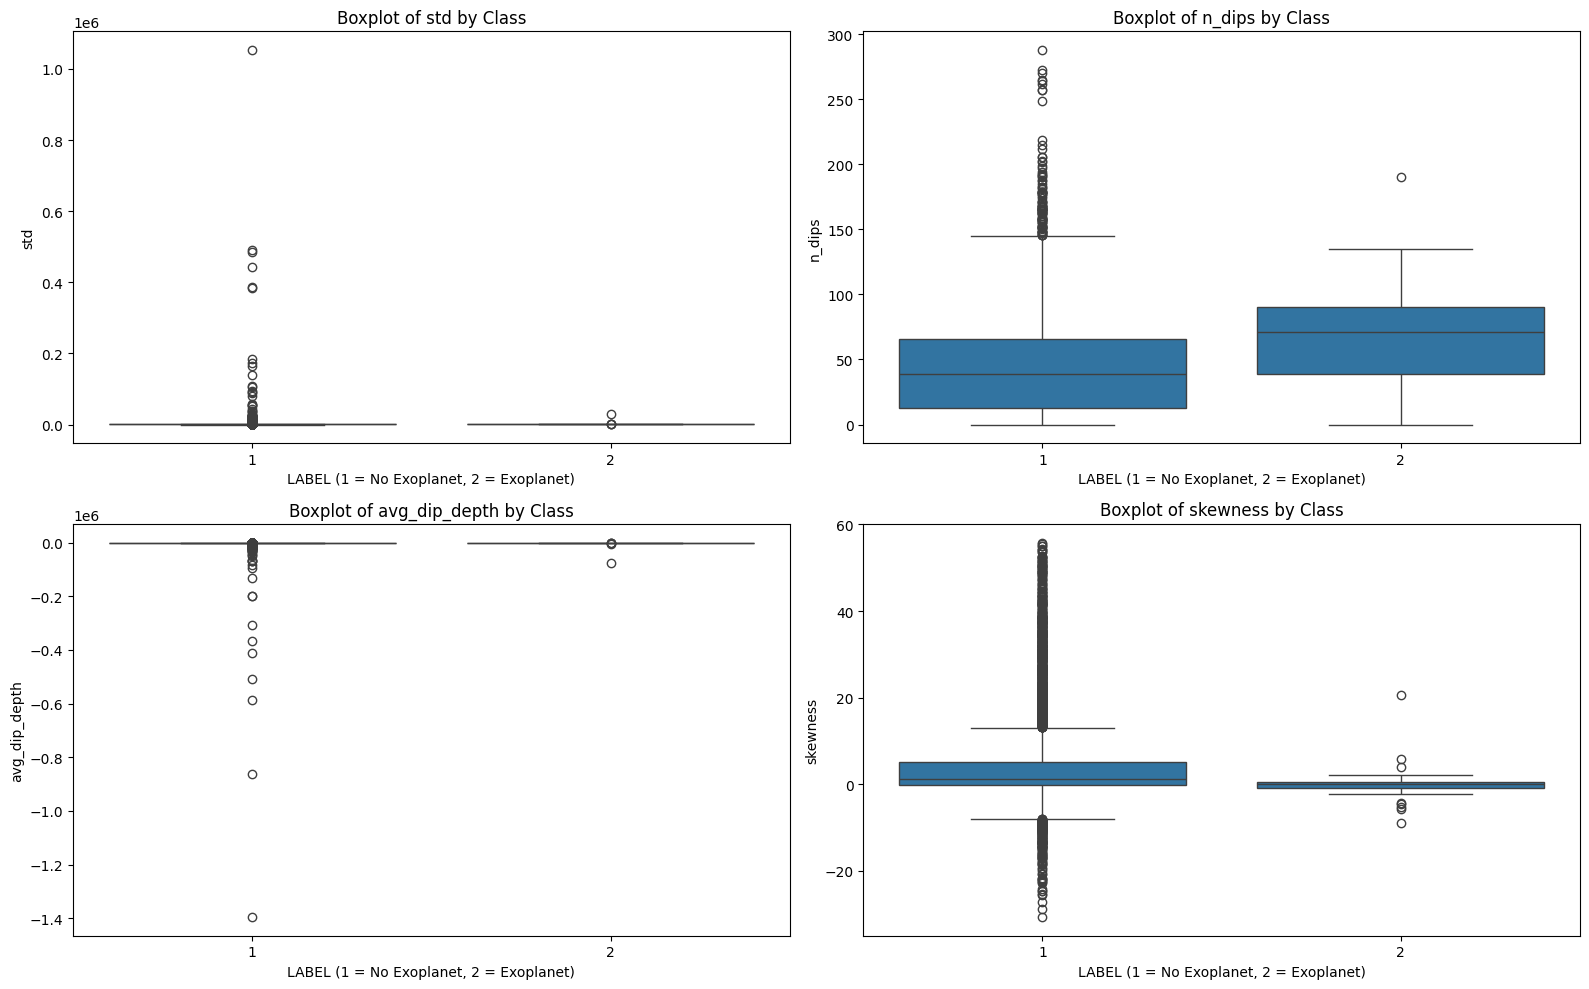

In [4]:
# Exoplanet_FeatureEngineering.ipynb
# Feature engineering on flux curves for traditional ML models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis

# --- Configuration ---
TRAIN_CSV_PATH = 'exoTrain.csv'
TEST_CSV_PATH = 'exoTest.csv'

# --- Load Data ---
def load_data(train_path, test_path):
    print("Loading datasets...")
    df_train = pd.read_csv(train_path)
    df_test = pd.read_csv(test_path)
    return df_train, df_test

# --- Feature Extraction Function ---
def extract_features(df):
    features = []
    labels = df['LABEL'].values
    for i, row in df.drop('LABEL', axis=1).iterrows():
        flux = row.values
        mean = np.mean(flux)
        std = np.std(flux)
        min_flux = np.min(flux)
        max_flux = np.max(flux)
        flux_range = max_flux - min_flux

        # Dip detection (minima below threshold)
        dip_threshold = mean - 2 * std
        dips = flux[flux < dip_threshold]
        n_dips = len(dips)
        avg_dip_depth = dips.mean() if n_dips > 0 else 0

        # Duration: count longest sequence below threshold
        below = flux < dip_threshold
        max_duration = max((sum(1 for _ in group) for val, group in groupby(below) if val), default=0)

        # Skewness and kurtosis
        skew_val = skew(flux)
        kurt_val = kurtosis(flux)

        # Store features
        features.append([
            mean, std, min_flux, max_flux, flux_range,
            n_dips, avg_dip_depth, max_duration,
            skew_val, kurt_val
        ])

    columns = [
        'mean', 'std', 'min_flux', 'max_flux', 'range',
        'n_dips', 'avg_dip_depth', 'max_dip_duration',
        'skewness', 'kurtosis'
    ]
    return pd.DataFrame(features, columns=columns), labels

# --- Main ---
if __name__ == "__main__":
    from itertools import groupby

    df_train, df_test = load_data(TRAIN_CSV_PATH, TEST_CSV_PATH)
    X_train_feat, y_train = extract_features(df_train)
    X_test_feat, y_test = extract_features(df_test)

    # Add labels and save
    X_train_feat['LABEL'] = y_train
    X_test_feat['LABEL'] = y_test
    X_train_feat.to_csv("exoTrain_features.csv", index=False)
    X_test_feat.to_csv("exoTest_features.csv", index=False)

    print("Feature extraction completed and files saved:")
    print(" - exoTrain_features.csv")
    print(" - exoTest_features.csv")

    # --- Visualize Selected Feature Distributions ---
    selected_features = ['std', 'n_dips', 'avg_dip_depth', 'skewness']

    plt.figure(figsize=(16, 10))
    for i, feature in enumerate(selected_features):
        plt.subplot(2, 2, i + 1)
        sns.boxplot(x='LABEL', y=feature, data=X_train_feat)
        plt.title(f'Boxplot of {feature} by Class')
        plt.xlabel("LABEL (1 = No Exoplanet, 2 = Exoplanet)")
        plt.tight_layout()

    plt.show()